# Bag-of-Motifs tutorial for binary classification

For this tutorial we are going to train binary a model to predict mouse cardiomyocyte specific candidate regulatory elements (CRE) from background CRE from other 16 cell types. For this, we will use the snATAC-seq data from Pijuan-Sala et al 2020 [1].

snATAC-seq peaks were annotated to cell types based on their differential accessibility compared to other cell types, as defined using an exact Fisher's test based methodology. The reference genome of these peaks is mm10.

**Please set your working directory here!**

In [3]:
working_path <- '/g/data/zk16/xzhang/BOM/Tutorial/'

### Step 1_ Data process  

The data resources can be downloaded from the github (also provided in Supplementary Table 6).

The cell type annotation is indicated in the column "celltype_specificity". Note that some snATAC-seq peaks were annotated to multiple cell types. 

**?? Consider whether wrap this into the later script file, or create one to include this cell.**

In [43]:
filename <- paste(working_path, 'Pijuan_etal_table_S6.csv', sep = "")

# load snATAC data
mouseE8.25 <- read.csv(file = filename, header = T, stringsAsFactors = F)

# removing all the peaks that were not annotated to a cell type
mouseE8.25 <- mouseE8.25[!is.na(mouseE8.25$celltype_specificity),]

# only the peaks annotated to a single cell type
mouseE8.25 <- mouseE8.25[!grepl(pattern = ";", x = mouseE8.25$celltype_specificity),]

# remove any duplicated peaks (only keep the peak coordinates and cell type annotation)
mouseE8.25 <- unique(mouseE8.25[,c("peak_chr", "peak_start", "peak_end", "celltype_specificity")])

# have a look at the number of peaks annotated to each cell type
# as.data.frame(table(mouseE8.25$celltype_specificity))

suppressMessages(library(GenomicRanges))
mouseE8.25_gr <- with(mouseE8.25, GRanges(peak_chr, IRanges(peak_start+1, peak_end)))
mouseE8.25_gr <- sort(mouseE8.25_gr)

# Make sure peaks don't overlap with others
# x <- as.data.frame(GenomicRanges::findOverlaps(mouseE8.25_gr, mouseE8.25_gr))
# x[x$queryHits != x$subjectHits,]

# Save processed peak into a bed file
output_file <- paste(working_path, 'mouseE8.25_peaks.bed', sep = "")
write.table(x = mouseE8.25, file = output_file, col.names = F, row.names = F, quote = F, sep = '\t')

Have a look the processed peak data 

In [14]:
# head(mouseE8.25,4)

### Step 2_ Peak filter


we will use the script "filter_CREs.R" to filter the peaks. With the script, you can carry out multiple tasks.

e.g. 
- keeping only regions that are proximal to a transcription start site (TSS)
- keeping only regions located distally
- remove any regions overlapping exons
- adjust the width of the regions to ensure concistency. 

Use '--help' to display all the options.

``` Rscript filter_CREs.R --help ```

Required arguments:
- '--input_bed' : provide peak data in .bed format.
- '--annot'     : provide a genome annotation file (*.gtf).
- '--chr_sizes' : provide a genome size file.
- '--out_bed'   : provide a output filename.


**In this tutorial**, we are going to remove the peaks located within 1kb from a TSS and the peaks overlapping exons and then adjust the width of the peaks to 500bp, by running the below command in the terminal

```
Rscript filter_CREs.R --input_bed=mouseE8.25_peaks.bed --annot=/g/data/zk16/cc3704/mouse_data/Mus_musculus.GRCm38.92.gtf \
--remove_proximal=True --non_exonic=True --u=1000 --d=1000 --nbp=500 --chr_sizes=/g/data/zk16/cc3704/mouse_data/mouse_sizes_primary_genome_tab.txt \
--out_bed=mouseE8.25_peaks_filt.bed
```

> In this case, we set '--remove_proximal' and '--non_exonic' to 'True' to remove peaks proximal to a TSS and exonic peaks, respectively. 

> Set '--u' and '--d' to 1000 to denote the number of base pairs upstream and downstream of a TSS for the definition of proximal regions. 

> Use '--nbp' to set the final width of the peaks to be all 500bp (--nbp=500), the script will trim or extend the peaks from their centre to the specified width.

In [ ]:
# Execute in the terminal and modify to your own file path 
Rscript filter_CREs.R \
--input_bed=/g/data/zk16/xzhang/BOM/Tutorial/mouseE8.25_peaks.bed \ 
--annot=/g/data/zk16/cc3704/mouse_data/Mus_musculus.GRCm38.92.gtf \
--remove_proximal=True --non_exonic=True --u=1000 --d=1000 --nbp=500 \
--chr_sizes=/g/data/zk16/cc3704/mouse_data/mouse_sizes_primary_genome_tab.txt \
--out_bed=/g/data/zk16/xzhang/BOM/Tutorial/mouseE8.25_peaks_filt.bed


Loading packages...
Possible Ensembl SSL connectivity problems detected.
Please see the 'Connection Troubleshooting' section of the biomaRt vignette
vignette('accessing_ensembl', package = 'biomaRt')Error in curl::curl_fetch_memory(url, handle = handle) : 
  SSL certificate problem: certificate has expired

Reading CREs...
Reading genome annotation...
Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... OK
Removing exonic regions...
Removing proximal regions to TSSs...
Warning message:
In .get_cds_IDX(mcols0$type, mcols0$phase) :
  The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.
Reading chromosome sizes...
Adjusting CRE length...
Saving CREs...
Done


Now, we can have a look the number of CRE remaining per cell type after filtering.

In [11]:
filtered_peak_file <- paste(working_path, 'mouseE8.25_peaks_filt.bed', sep = "")
filtered <- read.table(file = filtered_peak_file, header=F, stringsAsFactors=F, sep ='\t')

# remove the unclear defined cell-types
filtered$V4 <- sub("/", "_", filtered$V4)
filtered$V4 <- sub(" ", "_", filtered$V4)

filtered <- filtered[!filtered$V4 %in% c("Notochord", "Ubiquitous"),]

for(i in unique(filtered$V4))
{
  write.table(x = filtered[filtered$V4 == i, ], file = paste0(working_path,"bed_files/", i, ".bed"), quote = F, col.names = F, row.names = F, sep ='\t')
}

head(filtered, 3)

,V1,V2,V3,V4
,<chr>,<int>,<int>,<chr>
1,10,100039699,100040199,Pharyngeal_mesoderm
2,10,100128203,100128703,Forebrain
3,10,100164375,100164875,Gut


Finally, show statistics of cell-type annotation.

In [12]:
# display in 2*17 
# as.data.frame(table(filtered$V4))

### Step_3 Motif Searching

In this step, we will look for TF binding motif instances in the CRE, by using **run_fimo.sh** script.

To run 'run_fimo.sh', you need provide below arguments.
```
run_fimo.sh: 
Usage: args [-o] [-g] [-b] [-m] 
-m means path to motif database
-g means path to genome reference fasta file
-o means set a output path (Default: ./Tutorial/motifs)
-b means path to bed file folder (Default: ./Tutorial/bed_files)
```

**Note that** this script will require to have **bedtools and fimo installed**. The vertebrate motifs from the [database GIMME Motifs](https://github.com/vanheeringen-lab/gimmemotifs) [2] are used in the tutorial. 

```run_fimo.sh  -m /gimme.vertebrate.v5.0.meme  -g /Mus_musculus_GRCm38.fa  -b /Tutorial/bed_files -o /Tutorial/motifs```
> It might take around 5 minutes for a bed file with ~1000 peaks, here we will process for 17 cell types.

After this step, you will get **motif search results for each cell type under output folder**.

### Step_4 Motif Counting

In this step, the motif counts matrix will be prepared for binary classification, by running '**matrix_for_binary_model.R**' script.

Use '--help' to display all the options.

```Rscript filter_CREs.R --help```

Required arguments:

- '--input_bed' : provide peak data in .bed format.
- '--annot' : provide a genome annotation file (*.gtf).
- '--chr_sizes' : provide a genome size file.
- '--out_bed' : provide a output filename.

In [16]:
Rscript matrix_for_binary_model.R --help

Usage: Rscript matrix_for_binary_model.R [options]

Options:
  --target_ct=<target_cell_type>    Name of the target cell type
  --data_path=<data_directory>     Path to the data directory
  --qval_thresh=<qvalue_threshold> Q-value threshold for filtering
  --out_filename=<output_filename> Name for the output file
  --help                           Display this help message


Here, we provide a more detailed example of generating a matrix to distinguish cardiomyocyte-specific CRE from  CRE specific to other cell types. 

**In this case**, 
we set -target_ct=Cardiomyocytes, indicating that Cardiomyocytes CRE are the target class and set a q-value cuttoff of 0.5 to filter motif instances (parameter --qval_thresh). 

In [15]:
Rscript matrix_for_binary_model.R 
--target_ct=Cardiomyocytes \
--data_path=./Tutorial/motifs \
--qval_thresh=0.5 \
--out_filename=Cardiomyocytes_vs_other_counts.txt

In the output matrix, every CRE will be represented by a row and columns represent different motifs. The last 2 columns contain the cell type annotation, "celltype" contains the actual cell type name and "binary_celltype" contains the cell tipy coded as a binary, 1 represents cardiomyocyte CRE and 0 represents background CRE.


In [2]:
counts <- read.table(file = "Cardiomyocytes_vs_other_counts.txt", header = T, stringsAsFactors = F
                     , sep = '\t')
head(counts[,c(head(colnames(counts)), tail(colnames(counts), 2))])

,GM.5.0.AP.2.0001,GM.5.0.AP.2.0002,GM.5.0.AP.2.0003,GM.5.0.AP.2.0004,GM.5.0.AP.2.0005,GM.5.0.AP.2.0006,celltype,binary_celltype
,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>
10:100164375-100164875,0,0,0,0,0,0,Gut,0
10:109905996-109906496,0,0,0,0,0,0,Gut,0
10:110994762-110995262,0,0,0,0,0,0,Spinal_cord,0
10:111550213-111550713,0,0,0,0,0,0,Gut,0
10:116288025-116288525,0,0,0,1,1,0,Endothelium,0
10:117861961-117862461,0,0,0,0,0,2,Surface_ectoderm,0


## Step_5 Model Training

Now, we can start model training! using **"train_binary.R"** script.

Use '--help' to display all the options.

```Rscript train_binary.R --help```

**Note that** the data will be splited for training, validation and test (60%, 20% and 20% respectively). 

In [2]:
Rscript train_binary.R --help

Usage: Rscript training_binary.R [options]
Options:
--input_data=<file>		Path to the input matrix of motif counts (required)
--data=<data>			The training data (default: dtrain)
--nrounds=<n>			Number of boosting rounds (default: 10000)
--eta=<value>			Learning rate (default: 0.01)
--max_depth=<n>		Maximum tree depth (default: 6)
--subsample=<value>		Subsample ratio of the training instances (default: 0.5)
--colsample_bytree=<value>	Subsample ratio of columns when constructing each tree (default: 0.5)
--objective=<name>		Objective function (default: binary:logistic)
--early_stopping_rounds=<n>	Perform early stopping if no improvement for this many rounds (default: NULL)
--nthread=<n>			Number of parallel threads (default: 1)
--eval_metric=<name>		Evaluation metric (default: error)
--maximize=<bool>		Whether to maximize the evaluation metric (default: FALSE)
--save_period=<n>		Save the model for every given number of rounds (default: NULL)
--save_name=<file>		Name of the saved model file

Here is a **detailed example**, we set --early_stopping_rounds as 100 to stop model training when loss does not decrease after 100 iterations.


In [3]:
Rscript train_binary.R --input_data=Cardiomyocytes_vs_other_counts.txt --save_name=Cardiomyocytes_vs_other.rds --early_stopping_rounds=100 --print_every_n=100 --nthread=4

Reading data...
Splitting data into training, validation and test sets...
Training model...
[1]	train-error:0.149182	validation-error:0.195965 
Multiple eval metrics are present. Will use validation_error for early stopping.
Will train until validation_error hasn't improved in 100 rounds.

[101]	train-error:0.057748	validation-error:0.072046 
[201]	train-error:0.038499	validation-error:0.063401 
[301]	train-error:0.029836	validation-error:0.051873 
[401]	train-error:0.014437	validation-error:0.034582 
Stopping. Best iteration:
[395]	train-error:0.014437	validation-error:0.031700

Saving model...
Done


## Step_6 Model Predicting

Now, we use trained model to predict on the test set, by using **"predict_binary.R"** script. 

Use '--help' to display all the options.

```Rscript predict_binary.R --help```

**Note that** if we provide a file name to the argument --training_set we will save that training data which we will use for the interpretation of the model.

In [8]:
Rscript predict_binary.R --help

Usage: Rscript xgboost_predictions.R [parameters]

Parameters:
--input_data=<file>       Path to the input data file
--xgb_model=<file>        Path to the xgboost model file
--predictions=<file>      Path to save the predicted values
--training_set=<file>     Path to save the training set (optional)
--help                    Display this help message



In [4]:
Rscript predict_binary.R --input_data=Cardiomyocytes_vs_other_counts.txt --xgb_model=Cardiomyocytes_vs_other.rds --training_set=Cardiomyocytes_vs_other_train.txt --pred=Cardiomyocytes_vs_other_pred.txt

head Cardiomyocytes_vs_other_pred.txt


Reading model...
[1] TRUE
Best tree: 395 
Reading data...
Saving training set...
Saving predicted values...
Done
true_class predicted_class prob
10:100164375-100164875 0 0 0.0236886981874704
10:110994762-110995262 0 1 0.6538205742836
10:111550213-111550713 0 0 0.23369137942791
10:35328514-35329014 0 0 0.054384171962738
10:35452130-35452630 0 0 0.0358559265732765
10:60165918-60166418 0 0 0.0504816211760044
10:84477610-84478110 0 0 0.13245040178299
11:109350049-109350549 0 0 0.113616354763508
11:112978777-112979277 0 0 0.0942301899194717


The output file contains 3 columns. The first column indicates the true class of the CRE, 1 representing cardiomyocyte CRE and 0 representing background CRE. The second column represents the predicted classes coded as a binary with a threshold of > 0.5. The last column represents the predicted probability by the model. We can use these values to calculate some metrics of performance. 

By executing the following script, we will get values for the area under the Receiver Operating Characteristic (ROC) curve (auROC), area under the precision/recall curve (auPR), accuracy, F1 score, recall and precision. A ROC curve represents the relationship between sensitivity and specificity of the predictions across multiple decision thresholds. A precision/recall curve represents the relationship between precision and recall.


In [5]:
Rscript binary_stats.R --input_file=Cardiomyocytes_vs_other_pred.txt

Loading packages...
[1] "Cardiomyocytes_vs_other_pred.txt"
auROC: 0.9938 
auPR: 0.9943 
Accuracy: 0.9597 
F1 score: 0.96 
Recall: 0.96 
Precision: 0.96 


## Step_7 Prediction visualization

The prediction metrics give us a good idea of the performance of the model but we can also visualize the predictions. We can, for instance, produce a ROC or PR curve. 


In [ ]:
?? maybe just display ROC and PR curve here is enough

Setting levels: control = 0, case = 1



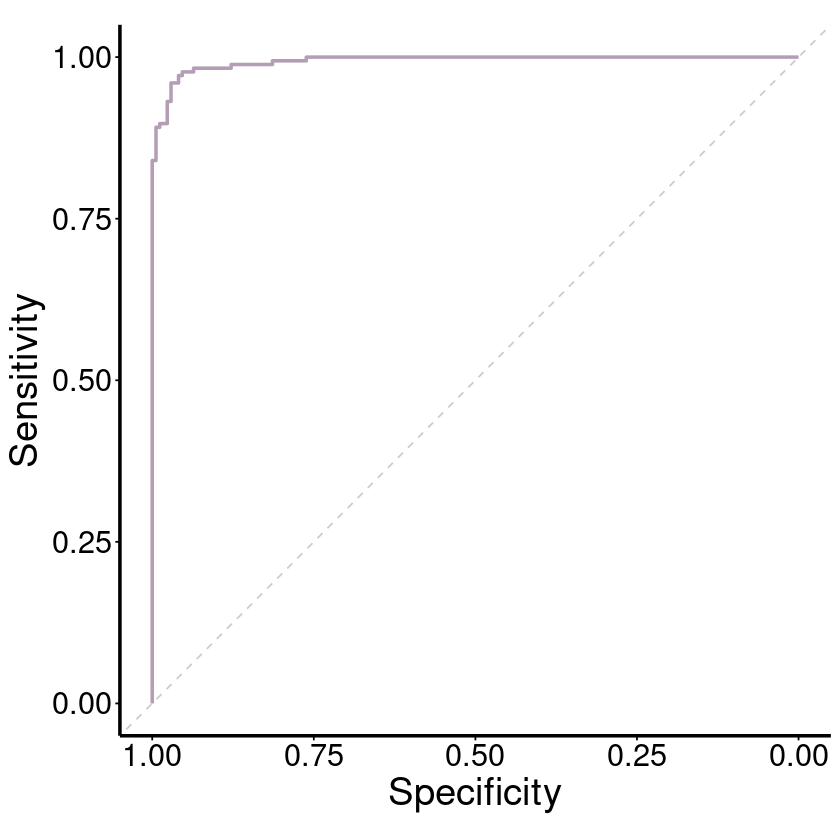

In [2]:
suppressMessages(library(cvAUC))
suppressMessages(library(pROC))
suppressMessages(library(ggplot2))

pred_tab <- read.table(file = "Cardiomyocytes_vs_other_pred.txt", header = T, stringsAsFactors = F)
roc_pred_tab <- roc(pred_tab$true_class, pred_tab$prob, direction="<")
rocs.list <- list(roc_pred_tab)
# Plot ROC curves
p <- ggroc(rocs.list, size = 1) + theme(panel.border = element_blank(), panel.grid.major = element_blank()
                                        , panel.grid.minor = element_blank()#legend.position="none" 
                                        , axis.line = element_line(colour = "black", size = 1)
                                        , legend.title = element_blank()
                                        , legend.key=element_blank()
                                        , legend.position = "none"
                                        , legend.key.width = unit(1.5,"cm")
                                        , panel.background = element_blank()
                                        , text = element_text(size=23)
                                        , axis.text.x=element_text(colour="black")
                                        , axis.text.y=element_text(colour="black")
                                        , legend.text=element_text(size=24)
                                        , axis.ticks = element_line(colour = "black")) +
  guides(linetype = guide_legend(override.aes = list(size = 3))) +
  geom_abline(slope=1, intercept = 1, linetype = "dashed", alpha=0.8, color = "grey") + coord_equal() +
  scale_colour_manual(values=c("#B39EB5"), aesthetics = c("colour", "fill")) +
  labs(y= "Sensitivity", x = "Specificity")

p

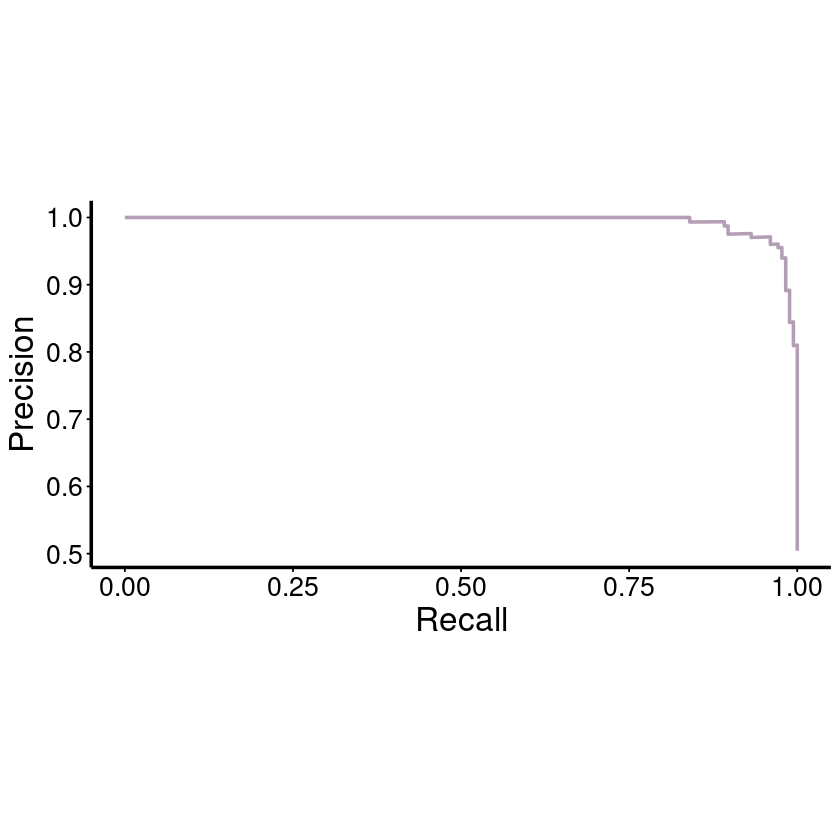

In [3]:
suppressMessages(library("yardstick"))
suppressMessages(library("cvAUC"))
suppressMessages(library(pROC))
suppressMessages(library(ggplot2))

pred_tab <- read.table(file = "Cardiomyocytes_vs_other_pred.txt", header = T, stringsAsFactors = F)

pred_tab$true_class <- factor(pred_tab$true_class, levels=c(0,1))  
curve <- pr_curve(pred_tab, truth=true_class, prob, event_level="second")

my_theme <-  theme(panel.border = element_blank(), panel.grid.major = element_blank()
                   , panel.grid.minor = element_blank()#legend.position="none"
                   , axis.line = element_line(colour = "black", size = 1)
                   , legend.title = element_blank()
                   , legend.key=element_blank()
                   , legend.position = c(0.75, 0.25)
                   , legend.key.width = unit(1,"cm")
                   , panel.background = element_blank()
                   , legend.text=element_text(size=15)
                   , text = element_text(size=20)
                   , axis.text.x=element_text(colour="black")
                   , axis.text.y=element_text(colour="black")
                   , axis.ticks = element_line(colour = "black"))

p <- ggplot(curve, aes(x = recall, y = precision)) +
  geom_path(color="#B39EB5", size = 1) +   my_theme +
  labs(y= "Precision", x = "Recall") + coord_equal()
#  scale_colour_manual(values=) + #, aesthetics = c("colour", "fill"))

p


### References

1. Pijuan-Sala, B., Wilson, N. K., Xia, J., Hou, X., Hannah, R. L., Kinston, S., ... & Göttgens, B. (2020). Single-cell chromatin accessibility maps reveal regulatory programs driving early mouse organogenesis. Nature cell biology, 22(4), 487-497.
2. Bruse, N., & Heeringen, S. J. V. (2018). GimmeMotifs: an analysis framework for transcription factor motif analysis. BioRxiv, 474403.
3. Charles E. Grant, Timothy L. Bailey and William Stafford Noble, "FIMO: Scanning for occurrences of a given motif", Bioinformatics 27(7):1017-1018, 2011. [full text]
4. Quinlan, A. R., & Hall, I. M. (2010). BEDTools: a flexible suite of utilities for comparing genomic features. Bioinformatics, 26(6), 841-842.
5. Lundberg, S. M., Erion, G., Chen, H., DeGrave, A., Prutkin, J. M., Nair, B., ... & Lee, S. I. (2020). From local explanations to global understanding with explainable AI for trees. Nature machine intelligence, 2(1), 56-67.